In [ ]:
!pip install openai langsmith langchain_community PyPDF2 pandas matplotlib --upgrade
!pip install pandas==2.2.2
!pip install langchain-huggingface

In [1]:
import os
import re
import PyPDF2
import pandas as pd
import matplotlib.pyplot as plt
from openai import OpenAI
from IPython.display import display
from openai import OpenAI
from langsmith import Client
from langsmith.evaluation import evaluate, LangChainStringEvaluator
from langsmith.schemas import Example



In [2]:
# OpenAI API 키 설정 (사용자가 입력해야 함)
# from google.colab import userdata
# api_key=userdata.get('api_key')
# os.environ["OPENAI_API_KEY"] = api_key
# api_key2=userdata.get('api_key2')
# os.environ["LANGCHAIN_API_KEY"] = api_key2

from dotenv import load_dotenv

load_dotenv()
# OpenAI API 클라이언트 생성
OPENAPI_KEY = os.getenv("OPENAI_API_KEY")
LangSmith_KEY = os.getenv("LANGCHAIN_API_KEY")

# 2) LangSmith 연동 필수 환경변수
os.environ["LANGCHAIN_TRACING_V2"] = "true"      # 트레이싱 활성화
os.environ["LANGSMITH_ENDPOINT"]   = "https://api.smith.langchain.com"  # 기본값
os.environ["LANGSMITH_PROJECT"]    = "RAG_EV_pdf_ex"                 # 수업용 프로젝트명




In [5]:
from langsmith import Client
from langsmith.evaluation import evaluate, LangChainStringEvaluator
from langsmith.schemas import Example
from langchain.schema import Document


client = OpenAI(api_key=os.environ["OPENAI_API_KEY"])
ls_client = Client()


# ============================================
# 3. PDF 읽기
# ============================================
# pdf_path = "/content/SPRi AI Brief_8월호_산업동향_F.pdf"
pdf_path = "./SPRi AI Brief_8월호_산업동향_F.pdf"

def extract_text_from_pdf(pdf_path):
    text = ""
    with open(pdf_path, "rb") as f:
        reader = PyPDF2.PdfReader(f)
        for page in reader.pages:
            text += page.extract_text() + "\n"
    return text

# document_text = extract_text_from_pdf(pdf_path)
# print("✅ 문서 길이:", len(document_text))


In [3]:
# 패키지 전체 리로드 (더 확실함)
import sys
import importlib

import sys
import os
sys.path.insert(0, os.path.abspath('..'))

## 패키지 전체 리로드 (더 확실함)
# import sys
# import importlib
# if 'a_my_rag_module' in sys.modules:
#     importlib.reload(sys.modules['a_my_rag_module'])


In [ ]:
import sys
import os
from a_my_rag_module.embedding import VectorStoreManager
from a_my_rag_module.retriever import AdvancedHybridRetriever
from a_my_rag_module.pdf_loader import PDFProcessor
from a_my_rag_module.splitter import KoreanTextSplitter

# a_my_rag_module를 사용하기 위해 프로젝트 루트 경로를 sys.path에 추가
project_root = os.path.abspath(os.path.join(os.getcwd(), '..'))
if project_root not in sys.path:
    sys.path.insert(0, project_root)


pdf = PDFProcessor()
documents = pdf.process_pdf(pdf_path)

# ========== 4-1. 텍스트 분할 ==========
text_splitter = KoreanTextSplitter(
    chunk_size=300,
    chunk_overlap=50
)


chunks = text_splitter.split_documents(documents=documents)
print(f"생성된 청크 수: {len(chunks)}")

# 3. 임베딩 모델 로드 및 벡터 스토어 생성
print("3. 임베딩 모델 로드 및 벡터 스토어 생성 중...")
vector_manager = VectorStoreManager(save_directory="./faiss_indexes")  # 저장할 디렉토리 지정

vector_store = vector_manager.auto_save_after_creation(
    documents=chunks,
    index_name="pdf_ev_ex1"
)


생성된 청크 수: 191
3. 임베딩 모델 로드 및 벡터 스토어 생성 중...
Loading embedding model: jhgan/ko-sroberta-multitask (~300MB)
임베딩 및 벡터 스토어 생성 중... (모델: ko-sroberta-multitask)
✅ 벡터 스토어 저장 완료: ./faiss_indexes/pdf_ev_ex1_ko-sroberta-multitask
4. Reranker 모델 로드 중...
5. 고급 하이브리드 검색기 생성 중...
Loading reranker: cross-encoder/ms-marco-MiniLM-L-6-v2 (~80MB)


### load from db file

In [26]:
print("\n=== 6. 새로운 매니저로 인덱스 로드 테스트 ===")
new_manager = VectorStoreManager(save_directory="./faiss_indexes")

# 저장된 인덱스 로드
load_result = new_manager.load_vector_store(
    index_name="pdf_ev_ex1",
    model_key="ko-sroberta-multitask"
)
print(load_result)

vector_store = new_manager.current_vector_store


=== 6. 새로운 매니저로 인덱스 로드 테스트 ===
Loading embedding model: jhgan/ko-sroberta-multitask (~300MB)
✅ 벡터 스토어 로드 완료: pdf_ev_ex1_ko-sroberta-multitask (생성일: 2025-09-01T23:45:57.429892, 문서수: 191)


In [29]:


# 4. Reranker 로드
print("4. Reranker 모델 로드 중...")

# 5. 고급 검색기 생성
print("5. 고급 하이브리드 검색기 생성 중...")
retriever = AdvancedHybridRetriever(
    chunks, vector_store
)


4. Reranker 모델 로드 중...
5. 고급 하이브리드 검색기 생성 중...
Loading reranker: cross-encoder/ms-marco-MiniLM-L-6-v2 (~80MB)


In [30]:

question = "대만에서 AI 관련 뉴스 알려줘"
# res = retriever.search_by_keyword(question)
res = retriever.advanced_search(question, method="hybrid",use_rerank= True)

for doc in res:
    print("------------")
    if doc.metadata.get('searchable_content') is not None :
        print(doc.metadata.get('searchable_content'))

Reranked 15 documents to top 5 with model: cross-encoder-ms-marco
------------
Contents 동일한 뉴스 기사에 대하여 AI 사용을 밝히면 인간과 LLM 모두 평가 하락 n 미국 프린스턴 와 워싱턴 등의 연구진이 2025년 7월 2일 AI 사용 여부와 저자의 인구통계학적 특성이 뉴스 기사 품질의 판단에 미치는 영향을 조사한 연구 결과를 공개 연구진은 1,970명의 참가자를 AI 사용 여부 저자 인종(아시아인, 흑인, 백인) 저자 성별(남성, 여성, 논바이너리)의 3개 독립 변수에 따라 18개 시험 조건 중 하나에 무작위로 배정 인간이 작성한 동일한 뉴스 기사를 읽고 평가한 결과, AI를 사용했다고 밝힌 contents 동일하다 뉴스 기사 대하 사용 밝히다 인간 llm 모두 평가 하락 미국 프린스턴 오다 워싱턴 구진 사용 여부 저자 인구 통계학 특성 뉴스 기사 품질 판단 미치다 영향 조사 연구 결과 공개 구진 명의 참가자 사용 여부 저자 인종 아시아 흑인 백인 저자 성별 남성 여성 바이너리 독립 변수 따르다 시험 조건 하나 무작위 배정 인간 작성 동일하다 뉴스 기사 읽다 평가 결과 사용 하다 밝히다 사용 뉴스 기사 저자 동일하다 밝히다 인간 평가 구진 여부 결과 contents 대하 llm 모두 하락 미국 프린스턴 오다 워싱턴 인구 통계학 특성 품질 판단 미치다 영향 조사 연구 공개 명의 참가자 인종 아시아 흑인 백인 성별 남성 여성 바이너리 독립 변수 따르다 시험 조건 하나 무작위 배정 작성 읽다 하다
------------
AI 검색, 어니 와 딥시크 모델 기반으로 다양한 입출력 형태를 지원 n 중국의 대표적인 검색엔진 기업 바이두(Baidu)가 2025년 7월 2일 AI Day 행사를 열고 10년 만에 최대 규모로 검색 플랫폼을 개편한다고 발표 수십 자까지만 입력할 수 있었던 기존 검색창을 스마트 검색 박스(Smart Search Box) 로 전환해, 1,000자가 넘는 중국어 텍스트 입력을 

In [31]:
# 전체 뉴스 요약
context = "\n".join([doc.page_content for doc in chunks[:100]])
print(f"context len: {len(context)}")

document_text = context

context len: 22519


📌 생성된 질문: ['1. **추론형 질문**: 대만 디지털발전부의 AI 산업 발전 정책이 민간 주도의 건전한 AI 산업 발전에 미치는 영향은 무엇일까요?', '2. **단순 factual 질문**: 대만 디지털발전부가 보고한 AI 산업 발전 정책의 5대 핵심 도구는 무엇인가요?', '3. **조건형 질문**: 만약 대만 디지털발전부가 AI 스타트업에 대한 자금 지원을 늘린다면, AI 산업의 발전 속도는 어떻게 변할 가능성이 있을까요?']


,질문,답변,관련성,정확성,논리성,간결성,총평
0,1. **추론형 질문**: 대만 디지털발전부의 AI 산업 발전 정책이 민간 주도의 ...,대만 디지털발전부의 AI 산업 발전 정책은 민간 주도의 건전한 AI 산업 발전에 여...,5,5,5,4,
1,2. **단순 factual 질문**: 대만 디지털발전부가 보고한 AI 산업 발전 ...,대만 디지털발전부가 보고한 AI 산업 발전 정책의 5대 핵심 도구는 다음과 같습니다...,5,1,3,4,
2,3. **조건형 질문**: 만약 대만 디지털발전부가 AI 스타트업에 대한 자금 지원...,"대만 디지털발전부가 AI 스타트업에 대한 자금 지원을 늘린다면, AI 산업의 발전 ...",5,5,5,4,


/Users/kwangsiklee/miniforge3/envs/langchain/lib/python3.10/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 51216 (\N{HANGUL SYLLABLE JEOM}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/Users/kwangsiklee/miniforge3/envs/langchain/lib/python3.10/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 49688 (\N{HANGUL SYLLABLE SU}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/Users/kwangsiklee/miniforge3/envs/langchain/lib/python3.10/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 54217 (\N{HANGUL SYLLABLE PYEONG}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/Users/kwangsiklee/miniforge3/envs/langchain/lib/python3.10/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 44512 (\N{HANGUL SYLLABLE GYUN}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/Users/kwangsiklee/miniforge3/envs/langchain/lib/python3.10/site

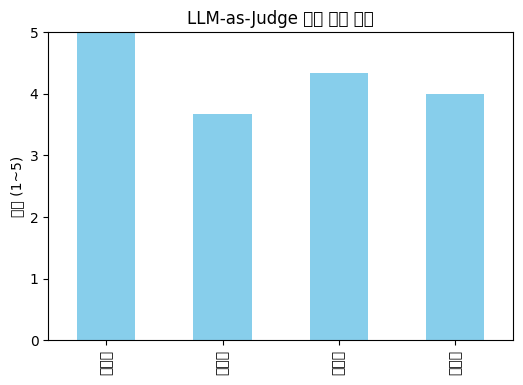

OSError: Cannot save file into a non-existent directory: '/content'

In [ ]:

# ============================================
# 4. 질문 생성
# ============================================
def generate_questions(text, n=3):
    prompt = f"""
    문서를 참고해서 다양한 질문 {n}개를 생성하라.
    - 추론형
    - 단순 factual
    - 조건형 (만약 ~라면?)

    문서 내용:
    {text[:1500]}
    """
    resp = client.chat.completions.create(
        model="gpt-4o-mini",
        messages=[{"role":"user","content":prompt}],
        temperature=0.7
    )
    return [q for q in resp.choices[0].message.content.split("\n") if q.strip()]

questions = generate_questions(document_text, n=3)
print("📌 생성된 질문:", questions)

# ============================================
# 5. 답변 생성
# ============================================
def answer_question(question, context):
    prompt = f"""
    다음 문서를 기반으로 질문에 답하라.

    문서 일부:
    {context[:2000]}

    질문: {question}
    """
    resp = client.chat.completions.create(
        model="gpt-4o-mini",
        messages=[{"role":"user","content":prompt}],
        temperature=0.5
    )
    return resp.choices[0].message.content

# ============================================
# 6. 평가 (LLM-as-Judge)
# ============================================
def judge_answer(question, answer, reference_text):
    eval_prompt = f"""
    너는 LLM-as-Judge 평가자이다.
    아래 질문과 답변을 평가하라.

    문서 일부:
    {reference_text[:1000]}

    질문: {question}
    답변: {answer}

    평가 기준:
    - 관련성 (1~5)
    - 정확성 (1~5)
    - 논리성 (1~5)
    - 간결성 (1~5)

    출력 형식:
    관련성: x
    정확성: x
    논리성: x
    간결성: x
    총평: 간단 코멘트
    """
    resp = client.chat.completions.create(
        model="gpt-4o-mini",
        messages=[{"role":"user","content":eval_prompt}],
        temperature=0
    )
    return resp.choices[0].message.content

# ============================================
# 7. 실행 및 DataFrame 생성
# ============================================
records = []
for q in questions:
    ans = answer_question(q, document_text)
    eval_text = judge_answer(q, ans, document_text)

    scores = {"질문": q, "답변": ans, "관련성":0,"정확성":0,"논리성":0,"간결성":0,"총평":""}
    for line in eval_text.split("\n"):
        if "관련성" in line:
            match = re.search(r"\d+", line)
            if match: scores["관련성"] = int(match.group())
        elif "정확성" in line:
            match = re.search(r"\d+", line)
            if match: scores["정확성"] = int(match.group())
        elif "논리성" in line:
            match = re.search(r"\d+", line)
            if match: scores["논리성"] = int(match.group())
        elif "간결성" in line:
            match = re.search(r"\d+", line)
            if match: scores["간결성"] = int(match.group())
        elif "총평" in line:
            scores["총평"] = line.split(":",1)[-1].strip()

    records.append(scores)

df = pd.DataFrame(records)

# ============================================
# 8. DataFrame 출력
# ============================================
display(df)

# ============================================
# 9. 시각화
# ============================================
mean_scores = df[["관련성","정확성","논리성","간결성"]].mean()

plt.figure(figsize=(6,4))
mean_scores.plot(kind="bar", color="skyblue")
plt.title("LLM-as-Judge 평균 평가 점수")
plt.ylabel("점수 (1~5)")
plt.ylim(0,5)
plt.show()


In [27]:

# ============================================
# 10. CSV 저장 (선택 사항)
# ============================================
df.to_csv("./evaluation_results.csv", index=False, encoding="utf-8-sig")
print("📂 결과가 evaluation_results.csv 로 저장되었습니다.")

📂 결과가 evaluation_results.csv 로 저장되었습니다.
